# 验证meta-grating优化之后的结果

In [15]:
import math
import os

import meep.adjoint as mpa
import numpy as np
from autograd import grad
from autograd import numpy as npa
from autograd import tensor_jacobian_product
from matplotlib import pyplot as plt
from matplotlib.patches import Circle
from scipy import signal, special

import meep as mp
import nlopt  # need install nlopt
plt.style.use("seaborn")

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
np.random.seed(0)

os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
mp.verbosity(0)

/tmp/ipykernel_22949/2738694393.py:15: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


0

2.8917334433369423e-05


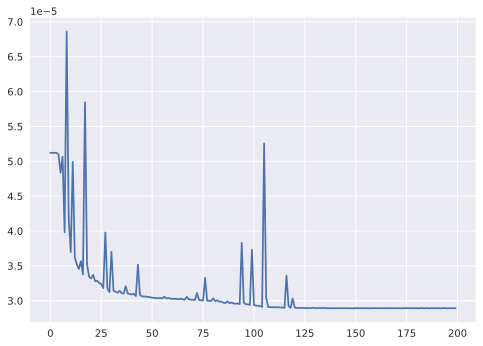

In [16]:
evaluation_history = np.load("eval_history_negative_3.npy")
plt.plot(evaluation_history)
print(evaluation_history[-1])

**Basic Setup**

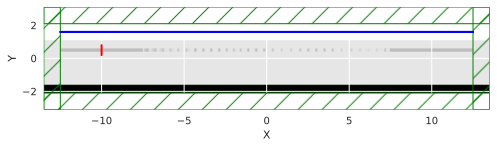

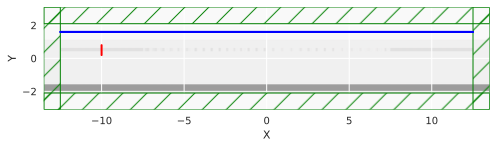

In [17]:
# if True compute flux (Gaussian source), if False compute DFT (Continue source)
compute_flux = True
# size of input and output waveguide
w = 0.5
h = 0.2

# resolution size
grid = 0.02
resolution = 1 / grid

# thickness of PML
dpml = 1

##################### length parameter ################
input_wvg_length = 5
output_wvg_length = 5
# design_region
design_region_x = 15
design_region_y = 0.2
sx = input_wvg_length + design_region_x + output_wvg_length + 2 * dpml

##################### height parameter ################
Substrate_thickness = 0.5
BOX_thickness = 2
TOX_thickness = 0.7
near_field_height = 1
sy = BOX_thickness + TOX_thickness + Substrate_thickness + near_field_height + 2 * dpml

cell = mp.Vector3(sx, sy, 0)

# Material setting
Si = mp.Medium(index=3.45)
SiO2 = mp.Medium(index=1.44)
SiN = mp.Medium(index=1.96)

####################### geometry ##########################
Substrate_geo = mp.Block(
    material=Si,
    center=mp.Vector3(y=-0.5 * sy + 0.5 * Substrate_thickness + dpml),
    size=mp.Vector3(sx, Substrate_thickness),
)
BOX_geo = mp.Block(
    material=SiO2,
    center=mp.Vector3(y=-0.5 * sy + Substrate_thickness + 0.5 * BOX_thickness + dpml),
    size=mp.Vector3(sx, BOX_thickness),
)
TOX_geo = mp.Block(
    material=SiO2,
    center=mp.Vector3(
        y=-0.5 * sy + Substrate_thickness + BOX_thickness + 0.5 * TOX_thickness + dpml
    ),
    size=mp.Vector3(sx, TOX_thickness),
)
input_waveguide_geo = mp.Block(
    material=SiN,
    center=mp.Vector3(
        -0.5 * sx + 0.5 * input_wvg_length + dpml,
        -0.5 * sy + Substrate_thickness + BOX_thickness + 0.5 * h + dpml,
    ),
    size=mp.Vector3(input_wvg_length, h),
)
output_waveguide_geo = mp.Block(
    material=SiN,
    center=mp.Vector3(
        0.5 * sx - 0.5 * output_wvg_length - dpml,
        -0.5 * sy + Substrate_thickness + BOX_thickness + 0.5 * h + dpml,
    ),
    size=mp.Vector3(output_wvg_length, h),
)

geometry = [
    Substrate_geo,
    BOX_geo,
    TOX_geo,
    input_waveguide_geo,
    output_waveguide_geo,
]

####################### geometry ##########################

# ####################### design region ##########################

design_region_resolution_x = int(resolution)
design_region_resolution_y = 5  # 200nm resolution
Nx = int(design_region_resolution_x * design_region_x)
Ny = int(design_region_resolution_y * design_region_y)
design_variables = mp.MaterialGrid(mp.Vector3(Nx, Ny), SiO2, SiN, grid_type="U_DEFAULT")
design_region = mpa.DesignRegion(
    design_variables,
    volume=mp.Volume(
        center=mp.Vector3(
            -0.5 * sx + input_wvg_length + 0.5 * design_region_x + dpml,
            -0.5 * sy + Substrate_thickness + BOX_thickness + 0.5 * h + dpml,
            0,
        ),
        size=mp.Vector3(design_region_x, design_region_y),
    ),
)
number_para = Nx * Ny
# 初始化granting coupler为最终优化结果
init_para = (
    np.abs(np.load("final_eps_negative_3.npy")[1 : number_para + 1, 5]) - 1.44**2
) / (1.96**2 - 1.44**2)
init_para[init_para > 1] = 1
init_para[init_para < 0] = 0
design_region.update_design_parameters(init_para)
geometry.append(
    mp.Block(
        center=design_region.center,
        size=design_region.size,
        material=design_variables,
    )
)
# ####################### design region ##########################

####################### Sources ##########################
wvl = 0.785
fcen = 1 / wvl
fwidth = 0.2 * fcen
kpoint = mp.Vector3(1, 0, 0)

# waveguide source
sources = [
    mp.EigenModeSource(
        mp.GaussianSource(frequency=fcen, fwidth=fwidth),
        center=input_waveguide_geo.center,
        size=mp.Vector3(0, 3 * h),
        eig_band=1,
        eig_parity=mp.EVEN_Y + mp.ODD_Z,
        eig_match_freq=True,
        direction=mp.NO_DIRECTION,
        eig_kpoint=kpoint,
    )
]
# set nomrlized source: amplitude is 1 -> flux is 1
sources[0].amplitude = 1 / mp.GaussianSource(fcen, fwidth=fwidth).fourier_transform(
    fcen
)

####################### Sources ##########################

sim = mp.Simulation(
    resolution=resolution,
    cell_size=cell,
    boundary_layers=[mp.PML(dpml)],
    sources=sources,
    geometry=geometry,
)

# ############### Monitor ###################
nfreq = 1

near_region = mp.FluxRegion(
    center=mp.Vector3(0, 0.5 * sy - dpml - 0.5 * near_field_height, 0),
    size=mp.Vector3(sx - 2 * dpml, 0),
)

near_field = sim.add_mode_monitor(
    fcen,
    0,
    1,
    near_region,
)

# near2far_field
n2f_field = sim.add_near2far(
    fcen,
    0,
    1,
    near_region,
)

sim.plot2D()

# mpt = mp.Vector3(input_waveguide_geo.center.x - 3, input_waveguide_geo.center.y)
mpt = mp.Vector3(output_waveguide_geo.center.x - 3, input_waveguide_geo.center.y)

f = plt.figure(dpi=100)
Animate = mp.Animate2D(fields=mp.Ez, f=f, realtime=False, normalize=True)

sim.run(
    mp.at_every(1, Animate),
    until_after_sources=mp.stop_when_fields_decayed(50, mp.Ez, mpt, 1e-5),
)
filename = "base_simulation_GS.mp4"
Animate.to_mp4(10, filename)

In [18]:
from IPython.display import Video
Video(filename)

## 远场验证

In [19]:
d_angle = 0.2
ff_distance = 1e6
ff_angle = 89
ff_number = int(2 / d_angle * ff_angle) + 1
ff_angles = np.linspace(-ff_angle, ff_angle, ff_number)
ff_points = [
    mp.Vector3(fx, 1e6, 0) for fx in np.tan(np.radians(ff_angles)) * ff_distance
]

start_angle = 0
stop_angle = 25

NearRegion = [
    mp.Near2FarRegion(
        center=mp.Vector3(0, 0.5 * sy - dpml - 0.5 * near_field_height, 0),
        size=mp.Vector3(sx - 2 * dpml, 0),
        weight=+1,
    )
]

# 归一化效率
efficiency = 0.76

ob_list = [mpa.Near2FarFields(sim, NearRegion, [ff_point]) for ff_point in ff_points]
final_intensity = np.load("norm_rel_negative.npy") * efficiency

/tmp/ipykernel_22949/590005896.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


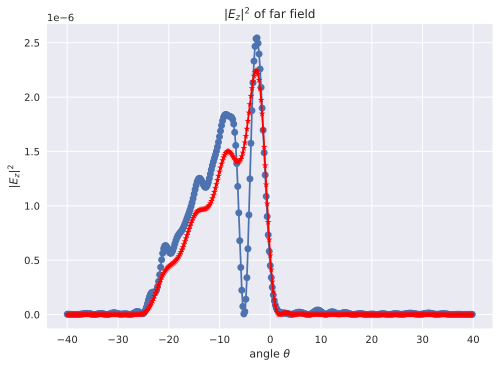

In [21]:
plt.style.use("seaborn")
n2f = []
for point in ff_points:
    ff = sim.get_farfield(n2f_field, point)
    n2f.append(ff)
rel = []
for ff in n2f:
    rel.append(np.abs(ff[2]) ** 2)

figure, ax = plt.subplots()
angle_minlim = np.where(ff_angles == -40)[0][0]
angle_maxlim = np.where(ff_angles == 40)[0][0]
plt.plot(
    ff_angles[angle_minlim:angle_maxlim], rel[angle_minlim:angle_maxlim], "-o"
)
plt.title(r"$ |{E_z}|^2 $ of far field")
ax.set_xlabel(r"angle $ \theta $")
ax.set_ylabel(r"$ |{E_z}|^2 $")
plt.plot(
    ff_angles[angle_minlim:angle_maxlim],
    0.6*final_intensity[angle_minlim:angle_maxlim],
    "-r*",
)

In [22]:
d_length = []
for angle in ff_angles:
    # The length of each angle in the far field
    length = ff_distance / np.cos(np.radians(angle))
    d_length.append(np.radians(d_angle) * length)

print(f"The total length {np.sum(d_length)} um calculated by angles")

energy = 0
for ii in range(0, ff_number, 1):
    energy = energy + d_length[ii] * (np.abs(rel[ii]))
print(f"The power of near_field is {energy}")

near_field_flux = mp.get_fluxes(near_field)
print(f"The power of near_field is {near_field_flux[0]}")


The total length 9689347.824509013 um calculated by angles
The power of near_field is 0.4879119745022755
The power of near_field is 0.48645267761484595


(752, 12)


/tmp/ipykernel_22949/520744896.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-paper")
/home/chen/miniconda3/envs/mp/lib/python3.11/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


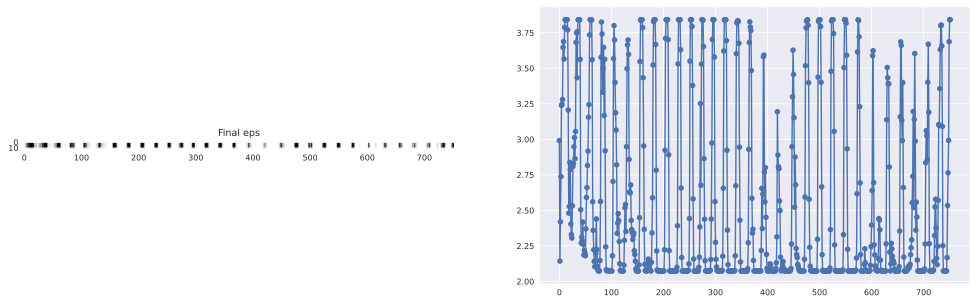

In [9]:
plt.style.use("seaborn-paper")
eps = np.load("final_eps_negative_2.npy")
print(eps.shape)
f1, ax = plt.subplots(1, 2, figsize=(17, 5))
ax[0].imshow(np.rot90(np.abs(eps)))
ax[0].set_title("Final eps")
ax[1].plot(eps[:, 5], "-o")

In [10]:
# 获得不同角度范围内的误差值
vf_obj_1 = 0
vf_obj_2 = 0
vf_obj_3 = 0

for angle in range(0, np.where(ff_angles == 0)[0][0] + 1, 1):
    vf_obj_1 += np.abs(rel[angle] - final_intensity[angle])
for angle in range(
    np.where(ff_angles == 0)[0][0], np.where(ff_angles == 25)[0][0] + 1, 1
):
    vf_obj_2 += np.abs(rel[angle] - final_intensity[angle])
for angle in range(np.where(ff_angles == 25)[0][0], ff_number, 1):
    vf_obj_3 += np.abs(rel[angle] - final_intensity[angle])
print(f"负角度：{vf_obj_1}")
print(f"0-25角度：{vf_obj_2}")
print(f"大角度：{vf_obj_3}")
print(vf_obj_1 + vf_obj_2 + vf_obj_3)

负角度：4.8214873061899444e-05
0-25角度：2.4091379468783483e-06
大角度：4.214458850024892e-07
5.1045456893780286e-05


## 近场 dft

Text(0, 0.5, '$ E_z $')

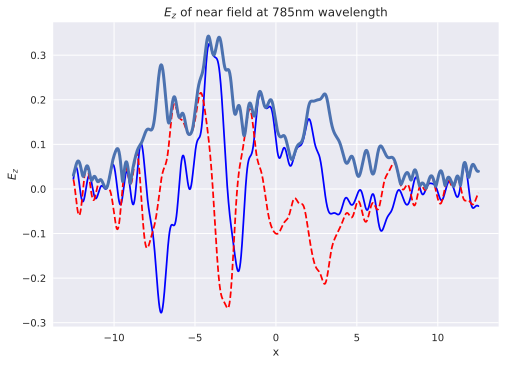

In [23]:
output_dft = sim.get_dft_array(near_field, mp.Ez, 0)
[x, y, z, w] = sim.get_array_metadata(dft_cell=near_field)

figure, ax = plt.subplots()
plt.plot(x, np.real(output_dft), "-b")
plt.plot(x, np.imag(output_dft), "--r")
plt.plot(x, np.abs(output_dft), linewidth=3)

plt.title(r"$ E_z $ of near field at 785nm wavelength")
ax.set_xlabel("x")
ax.set_ylabel(r"$ E_z $")